## Imports and API

In [135]:
# Libraries
from langgraph.graph import StateGraph
from graphviz import Digraph
from typing import TypedDict, List, Any
from openai import OpenAI
import requests
import feedparser
from dotenv import load_dotenv
import os

client = OpenAI()
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("API_KEY")

## ArVix search agent

In [136]:
def search_arxiv(query, max_results=5):
    url = f'http://export.arxiv.org/api/query?search_query={query}&start=0&max_results={max_results}'
    feed = feedparser.parse(requests.get(url).text)
    
    results = []
    for entry in feed.entries:
        results.append({
            'title': entry.title,
            'summary': entry.summary,
            'link': entry.link
        })
    return results


## OpenAlex search agent

In [137]:
def search_openalex(query, max_results=5):
    url = f"https://api.openalex.org/works?search={query}&per-page={max_results}"
    response = requests.get(url)
    data = response.json()
    
    results = []
    for item in data.get('results', []):
        results.append({
            'title': item.get('display_name', 'No Title'),
            'summary': item.get('abstract_inverted_index', {}),
            'link': item.get('id', 'No Link')
        })
    return results


In [138]:
def merge_results(arxiv_results, openalex_results):
    return arxiv_results + openalex_results

## Summerizing agent

In [ ]:
def summarize_papers(papers):
    content = "\n\n".join([f"Title: {p['title']}\nSummary: {p['summary']}" for p in papers])
    prompt = (
                "You are a professional research assistant tasked with critically summarizing academic papers.\n\n"
                "Carefully analyze each of the following research papers.\n"
                "For every paper, provide a structured summary that includes:\n"
                "- **Main Opportunities:** Clearly state the new possibilities, innovations, or contributions introduced by the research.\n"
                "- **Key Challenges or Limitations:** Highlight any obstacles, risks, limitations, or open questions discussed by the authors.\n"
                "- **Real-world Applications or Case Studies:** Identify practical applications, industry use cases, or concrete examples provided.\n"
                "- **If any of these points are missing in a paper, explicitly write 'Not discussed in the paper.'\n\n"
                "Your summary must be:\n"
                "- Professional, neutral, and concise.\n"
                "- Comprehensive enough for a research-oriented audience.\n"
                "- Avoid assumptions or filler content.\n"
                "- Reflect the actual content of the papers — do not invent details.\n\n"
                "Here are the research papers for your analysis:\n\n"
                f"{content}"
            )

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

In [140]:
def summarize_papers_with_prompt(papers, custom_instruction):
    content = "\n\n".join([f"Title: {p['title']}\nSummary: {p['summary']}" for p in papers])
    prompt = f"{custom_instruction}\n\nPapers:\n{content}"
    
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content


## Critic Agent

In [ ]:
def critique_summary(summary_text):
    prompt = (
                "You are a critical reviewer of academic research summaries.\n\n"
                "Carefully review the following summarized research papers.\n"
                "For each summary, analyze and provide clear feedback on:\n"
                "- **Completeness:** Are the main opportunities, key challenges or limitations, and real-world applications addressed as per the original research?\n"
                "- **Accuracy:** Does the summary reflect the actual content of the research without exaggeration, omission, or factual errors?\n"
                "- **Clarity and Specificity:** Is the summary clear, specific, and free from vague language or assumptions?\n"
                "- **Missing Details:** Are there important aspects like examples, case studies, or key findings that are missing and should be included?\n\n"
                "If a summary lacks information, suggest exactly what could be added or improved.\n"
                "Your critique should be professional, constructive, and concise.\n"
                "Do NOT rewrite the summary — only provide critique and suggestions.\n\n"
                "Summaries to Review:\n\n"
                f"{summary_text}"
            )

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    
    critique = response.choices[0].message.content
    
    if any(keyword in critique.lower() for keyword in ["missing", "improve", "bias", "error"]):
        return critique, 'needs_rewrite'
    else:
        return critique, 'approved'


## Verifier agent

In [142]:
def verify_summary(summary_text):
    prompt = (
        "Fact-check the following summary. "
        "Highlight any factual inaccuracies or unsupported claims:\n\n"
        f"{summary_text}"
    )
    
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    
    return response.choices[0].message.content


In [143]:
def compose_final_answer(summary, critique, verification):
    return f"Summary:\n{summary}\n\nCritique:\n{critique}\n\nVerification Notes:\n{verification}"

In [144]:
# state dictionary structure
state = {
    'user_query': '',
    'arxiv_results': [],
    'openalex_results': [],
    'merged_results': [],
    'summary': '',
    'critique': '',
    'verification': '',
    'final_output': '',
    'status': '' 
}

In [145]:
def search_arxiv_node(state):
    results = search_arxiv(state['user_query'], max_results=3)
    state['arxiv_results'] = results
    return state

def search_openalex_node(state):
    results = search_openalex(state['user_query'], max_results=3)
    state['openalex_results'] = results
    return state

def merge_results_node(state):
    merged = merge_results(state['arxiv_results'], state['openalex_results'])
    state['merged_results'] = merged
    return state

def summarizer_node(state):
    summary = summarize_papers(state['merged_results'])
    state['summary'] = summary
    return state

def critic_node(state):
    critique, status = critique_summary(state['summary'])
    state['critique'] = critique
    state['status'] = status 
    return state

def verifier_node(state):
    verification = verify_summary(state['summary'])
    state['verification'] = verification
    return state

def final_composer_node(state):
    final = compose_final_answer(state['summary'], state['critique'], state['verification'])
    state['final_output'] = final
    return state

In [146]:
class ResearchState(TypedDict):
    user_query: str
    arxiv_results: List[Any]
    openalex_results: List[Any]
    merged_results: List[Any]
    summary: str
    critique: str
    verification: str
    final_output: str
    status: str

In [147]:
def check_critique_status(state: ResearchState) -> str:
    return state['status']

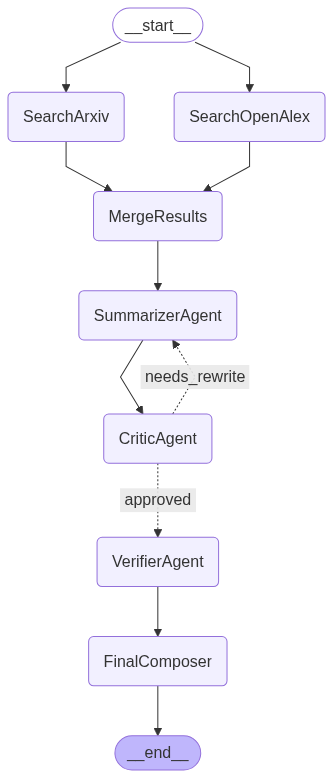

In [148]:
graph = StateGraph(ResearchState)

# Add Nodes
graph.add_node('SearchArxiv', search_arxiv_node)
graph.add_node('SearchOpenAlex', search_openalex_node)
graph.add_node('MergeResults', merge_results_node)
graph.add_node('SummarizerAgent', summarizer_node)
graph.add_node('CriticAgent', critic_node)
graph.add_node('VerifierAgent', verifier_node)
graph.add_node('FinalComposer', final_composer_node)

# Add Edges
graph.add_edge('__start__', 'SearchArxiv')
graph.add_edge('__start__', 'SearchOpenAlex')
graph.add_edge('SearchArxiv', 'MergeResults')
graph.add_edge('SearchOpenAlex', 'MergeResults')
graph.add_edge('MergeResults', 'SummarizerAgent')
graph.add_edge('SummarizerAgent', 'CriticAgent')

# Conditional Edge based on Critic output
graph.add_conditional_edges('CriticAgent', check_critique_status, {
    'needs_rewrite': 'SummarizerAgent',
    'approved': 'VerifierAgent'
})

graph.add_edge('VerifierAgent', 'FinalComposer')

graph.compile()

In [150]:
# Initialize state with user query
state['user_query'] = "Latest trends in AI and human-agent collaboration"

# Execute nodes manually for testing (or use compiled graph runner)
state = search_arxiv_node(state)
state = search_openalex_node(state)
state = merge_results_node(state)
state = summarizer_node(state)
state = critic_node(state)

# If Critic says 'needs_rewrite', loop
if state['status'] == 'needs_rewrite':
    state = summarizer_node(state)
    state = critic_node(state)

state = verifier_node(state)
state = final_composer_node(state)

print(state['final_output'])

Summary:
Title: Reflection on Data Storytelling Tools in the Generative AI Era from the Human-AI Collaboration Perspective

Main Opportunities:
- The research highlights the potential of large-scale generative AI techniques like large language models and text-to-image models to enhance data storytelling through visual and narration generation.
- Comparison of collaboration patterns between new and earlier tools reveals evolving approaches like AI-creator + human-reviewer collaborations.
- The study identifies benefits of AI techniques and implications for human-AI collaboration, setting the stage for future innovations.

Key Challenges or Limitations:
- The challenges and limitations of implementing these new AI techniques are not explicitly discussed within the summary.

Real-world Applications or Case Studies:
- The practical application of the research in data storytelling tools for human-AI collaboration is discussed, but specific real-world use cases are not provided in the summar